Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
import requests
import pandas as pd

# citybikes results
citybikes_df = pd.read_csv('citybikes_data.csv')

# Foursquare results
foursquare_df = pd.read_csv('fsq_data.csv')

# Yelp results
yelp_df = pd.read_csv('yelp_data.csv')

In [2]:
# Merge dataframes
# Join the DataFrames using concat
merged_df = pd.concat([citybikes_df, foursquare_df, yelp_df], axis=0)
merged_df.head(4)

,Station Name,Latitude,Longitude,Free Bikes,Empty slots,ll,Foursquare ID,Categories,Distance,Address,Country,Locality,Yelp ID,City,Name,Rating
0,Hess at king,43.259126,-79.877212,3.0,9.0,"43.259125842121065,-79.87721174955368",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bayfront Park,43.269288,-79.871327,10.0,25.0,"43.269288276229105,-79.87132698297499",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bay at Strachan,43.267859,-79.867923,4.0,18.0,"43.26785864558976,-79.8679232597351",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bay at Mulberry,43.263198,-79.871803,4.0,10.0,"43.263198441574474,-79.87180307507515",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 0 to 49
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Station Name   145 non-null    object 
 1   Latitude       245 non-null    float64
 2   Longitude      245 non-null    float64
 3   Free Bikes     145 non-null    float64
 4   Empty slots    145 non-null    float64
 5   ll             145 non-null    object 
 6   Foursquare ID  50 non-null     object 
 7   Categories     100 non-null    object 
 8   Distance       100 non-null    float64
 9   Address        100 non-null    object 
 10  Country        50 non-null     object 
 11  Locality       50 non-null     object 
 12  Yelp ID        50 non-null     object 
 13  City           50 non-null     object 
 14  Name           50 non-null     object 
 15  Rating         50 non-null     float64
dtypes: float64(6), object(10)
memory usage: 32.5+ KB


In [8]:
#convert to csv
merged_df_new = merged_df[['Station Name', 'Latitude', 'Longitude','Name','Categories', 'Distance', 'Address', 'City', 'Rating', 
                               'Empty slots']]
merged_df_new.to_csv('merged_data.csv', index=False)

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [9]:
# import ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [12]:
import folium

# map centered around London
map_hamilton = folium.Map(location=[43.2557, -79.8711], zoom_start=12)

# Adding markers for each data point in citybikes dataframe
for index, row in citybikes_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Station Name'],  # Replace with the appropriate column from your dataframe
        icon=folium.Icon(color='blue')
    ).add_to(map_hamilton)

# Display the map
map_hamilton

This visualization shows the locations of the bike stations in the city of Hamilton

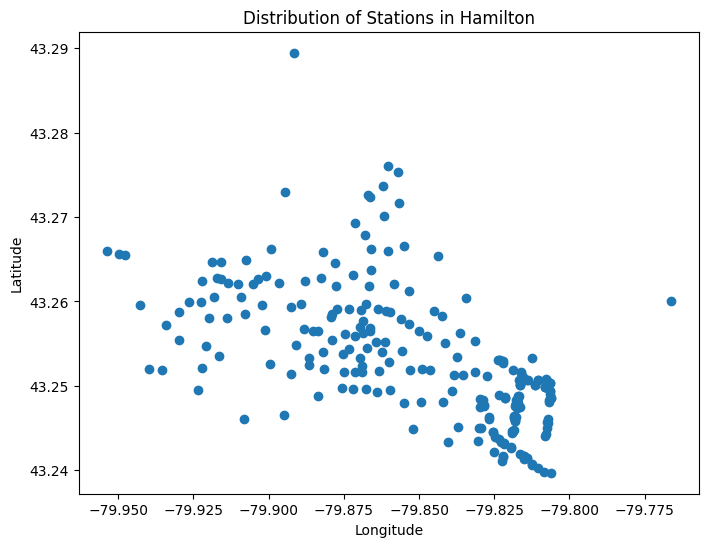

In [14]:
#scatterplot
plt.figure(figsize=(8, 6))  # Adjust the figure size as per your preference
plt.scatter(merged_df['Longitude'], merged_df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Stations in Hamilton')
plt.show()

We can see that there are more bikes in central Hamilton and a couple of outliers.

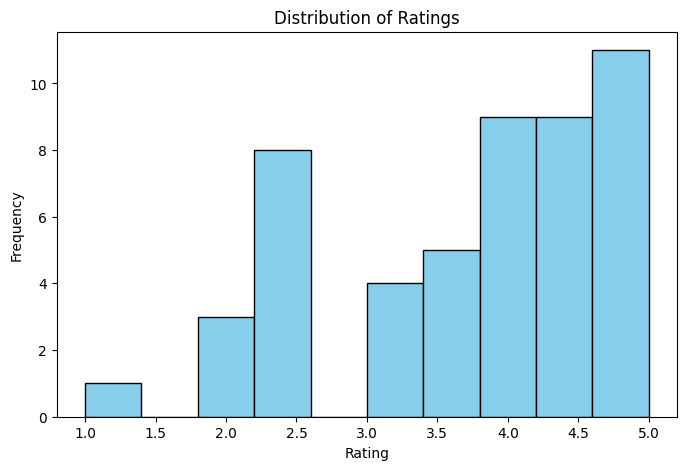

In [21]:
import matplotlib.pyplot as plt

# Create a histogram of ratings
plt.figure(figsize=(8, 5))
plt.hist(merged_df_new['Rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

C:\Users\halim\anaconda3\envs\project\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\halim\anaconda3\envs\project\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\halim\anaconda3\envs\project\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


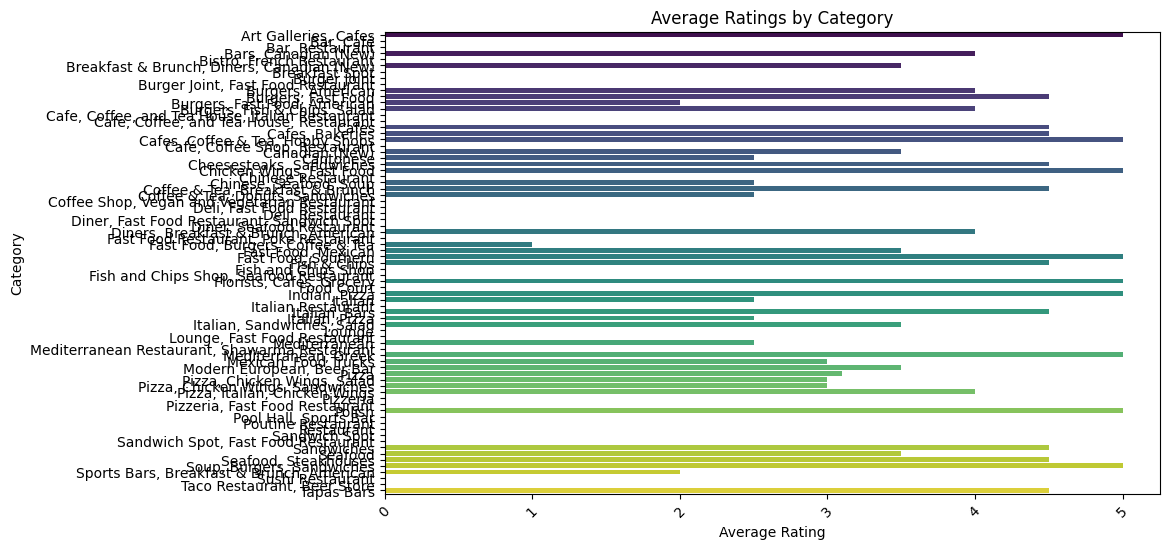

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'Categories' and calculate the average rating for each category
avg_ratings_by_category = merged_df_new.groupby('Categories')['Rating'].mean().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='Categories', data=avg_ratings_by_category, palette='viridis')
plt.title('Average Ratings by Category')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.xticks(rotation=45)
plt.show()

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [25]:
import sqlite3
from sqlite3 import Error
# using sqlalchemy
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection
connection = create_connection("sm_app.sqlite")

Connection to SQLite DB successful


In [101]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [51]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection("new_data.db")
# citybikes results
citybikes_df = pd.read_csv('citybikes_data.csv')

# Foursquare results
foursquare_df = pd.read_csv('fsq_data.csv')

# Yelp results
yelp_df = pd.read_csv('yelp_data.csv')

#joined results
merged_df = pd.read_csv('merged_data.csv')

citybikes_df.to_sql('citybikes', connection, if_exists='replace', index=False)
foursquare_df.to_sql('foursquare', connection, if_exists='replace', index=False)
yelp_df.to_sql('yelp', connection, if_exists='replace', index=False)
merged_df.to_sql('merged', connection, if_exists='replace', index=False)

print("Data added to the SQLite database.")

Connection to SQLite DB successful
Data added to the SQLite database.


Look at the data before and after the join to validate your data.

In [52]:
import pandas as pd

#convert dataframe to csv
citybikes_df.to_csv('citybikes.csv', index=False)
yelp_df.to_csv('yelp.csv', index=False)
foursquare_df.to_csv('foursquare.csv', index=False)
merged_df.to_csv('merged.csv', index=False)

In [53]:
# SQL query to select the top 5 records from the merged_df table
query = "SELECT * FROM merged"

# Execute the SQL query to select the top 5 records
query = "SELECT * FROM merged"
result_df = pd.read_sql_query(query, connection)

# View the result DataFrame
print(result_df)

# Close the database connection

        Station Name   Latitude  Longitude                   Name  \
0       Hess at king  43.259126 -79.877212                   None   
1      Bayfront Park  43.269288 -79.871327                   None   
2    Bay at Strachan  43.267859 -79.867923                   None   
3    Bay at Mulberry  43.263198 -79.871803                   None   
4          City Hall  43.256132 -79.874499                   None   
..               ...        ...        ...                    ...   
240             None  43.240320 -79.810500         Original Pizza   
241             None  43.239770 -79.808572         Domino's Pizza   
242             None  43.249817 -79.808151  BarBurrito - Hamilton   
243             None  43.247520 -79.829750       The Taco Station   
244             None  43.248370 -79.828710        Taste of Poland   

                           Categories     Distance  \
0                                None          NaN   
1                                None          NaN   
2        

In [54]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Name  145 non-null    object 
 1   Latitude      245 non-null    float64
 2   Longitude     245 non-null    float64
 3   Name          50 non-null     object 
 4   Categories    100 non-null    object 
 5   Distance      100 non-null    float64
 6   Address       100 non-null    object 
 7   City          50 non-null     object 
 8   Rating        50 non-null     float64
 9   Empty slots   145 non-null    float64
dtypes: float64(5), object(5)
memory usage: 19.3+ KB


In [ ]:
results = connection.execute(query).fetchall()

print(results)

In [ ]:
# Print the results
for row in results:
    print(row)

# Close the database connection
connection.close()

In [57]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Name  145 non-null    object 
 1   Latitude      245 non-null    float64
 2   Longitude     245 non-null    float64
 3   Name          50 non-null     object 
 4   Categories    100 non-null    object 
 5   Distance      100 non-null    float64
 6   Address       100 non-null    object 
 7   City          50 non-null     object 
 8   Rating        50 non-null     float64
 9   Empty slots   145 non-null    float64
dtypes: float64(5), object(5)
memory usage: 19.3+ KB
